In [1]:
import os, sys
import pickle
from PIL import Image
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import models
import utils as ut

path_setting = 'settings/separate_10.ini'

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombuffer( "RGBA", ( w ,h ), buf.tostring( ), 'raw', "RGBA", 0, 1)

def plot_image(x, args):
    F, T = x.shape
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', serif='Times', size=15)

    len_source = int(args.len_hop*(T-1))
    len_source_ms = len_source/args.f_sampling*1000

    fig, ax = plt.subplots(figsize=(args.figsize[0], args.figsize[1]), facecolor='lightblue')

    im = ax.imshow(x, origin='lower', cmap=cm.Blues)
 
    cb = fig.colorbar(im, pad=args.fig_pad, shrink=args.fig_shrink, fraction=args.fig_fraction)
    cb.outline.set_visible(False)
    axb = cb.ax

    axb.set_xlabel("{0:.0f}".format(np.min(x)))
    axt = axb.twiny()

    axt.set_xlabel("{0:.0f}".format(np.max(x)))
    axt.xaxis.set_ticks([])
    axt.yaxis.set_ticks([])

    axt.spines['top'].set_visible(False)
    axt.spines['bottom'].set_visible(False)
    axt.spines['right'].set_visible(False)
    axt.spines['left'].set_visible(False)

    ax.tick_params(axis='both', which='both', length=0, direction='in')

    start, end = ax.get_xlim()
    xticks = np.linspace(0, end, 5)
    ax.set_xticks(xticks)
    xtickslabels = ['{:.0f}'.format(s) for s in np.linspace(0, len_source_ms, len(xticks))]
    ax.set_xticklabels(xtickslabels)

    ax.set_xlabel('Time (ms)')

    start, end = ax.get_ylim()
    yticks = np.linspace(0, end, 5)
    ax.set_yticks(yticks)
    ytickslabels = ['{:.0f}'.format(s) for s in np.linspace(args.lst_f_range[0]/1e3, args.lst_f_range[1]/1e3, len(yticks))]
    ax.set_yticklabels(ytickslabels)
    ax.set_ylabel('Frequency (kHz)')
    plt.show()
    
    if hasattr(args, "fig_title"):
        ax.set_title(args.fig_title)

    if hasattr(args, 'path_fig'):
        pass
        # fig.savefig(args.path_fig, bbox_inches='tight')
    plt.close()

def set_colorbar(fig, x, im, ax, args):
    cb = fig.colorbar(im, ax=ax, pad=args.fig_pad, shrink=args.fig_shrink, fraction=args.fig_fraction)
    cb.outline.set_visible(False)
    axb = cb.ax

    axb.set_xlabel("{0:.0f}".format(np.min(x)))
    axt = axb.twiny()

    axt.set_xlabel("{0:.0f}".format(np.max(x)))
    axt.xaxis.set_ticks([])
    axt.yaxis.set_ticks([])

    axt.spines['top'].set_visible(False)
    axt.spines['bottom'].set_visible(False)
    axt.spines['right'].set_visible(False)
    axt.spines['left'].set_visible(False)
    
def plot_image_mask_(x, args):
    num_subplots = 2
    
    F, T = x.image.shape
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', serif='Times', size=15)

    len_source = int(args.len_hop*(T-1))
    len_source_ms = len_source/args.f_sampling*1000
    
    fig, axes = plt.subplots(num_subplots, 1, figsize=(args.figsize[0], args.figsize[1]*num_subplots))

    # image
    i_ax = 0
    ax = axes[i_ax]
    im = ax.imshow(x.image, origin='lower', cmap=cm.Blues)
    set_colorbar(fig, x.image, im, ax, args)

    ax.tick_params(axis='both', which='both', length=0, direction='in')

    start, end = ax.get_xlim()
    xticks = np.linspace(0, end, 5)
    ax.set_xticks(xticks)
    xtickslabels = ['{:.0f}'.format(s) for s in np.linspace(0, len_source_ms, len(xticks))]
    ax.set_xticklabels(xtickslabels)

    ax.set_xlabel('Time (ms)')

    start, end = ax.get_ylim()
    yticks = np.linspace(0, end, 5)
    ax.set_yticks(yticks)
    ytickslabels = ['{:.0f}'.format(s) for s in np.linspace(args.lst_f_range[0]/1e3, args.lst_f_range[1]/1e3, len(yticks))]
    ax.set_yticklabels(ytickslabels)
    ax.set_ylabel('Frequency (kHz)')

    # mask_
    i_ax += 1
    ax = axes[i_ax]
    im = ax.imshow(x.image, origin='lower', cmap='Blues')
    set_colorbar(fig, x.image, im, ax, args)
    if hasattr(x, 'mask_'):
        for m in x.mask_:
            mask = np.copy(m)
            mask[mask == 0] = np.nan
            color = [tuple(np.random.rand(3)), (1, 1, 1)]
            cmap = colors.LinearSegmentedColormap.from_list('random_binary_cmap', color, N=2)
            ax.imshow(mask, cmap = cmap, origin='lower', alpha=.5)
    #plt.show()
    if hasattr(args, 'path_fig'):
        fig.savefig(args.path_fig, bbox_inches=None)
    plt.close()
    return fig
    
    
def main():
    # settings
    args = ut.settings(path_setting)
    
    # path outputs
    args.path_sources_ = os.path.join("results", args.name_setting, "sources_")
    ut.make_dir(args.path_sources_)

    # path figures
    args.path_figures = os.path.join('results', args.name_setting, "figures")
    ut.make_dir(args.path_figures)
    
    # path model
    args.path_model = os.path.join('results', args.name_model, 'models')
    args.path_pth = os.path.join(args.path_model, "{}_{}.pth".format(args.name_model, args.i_fold))
    assert os.path.exists(args.path_pth), "{} doesn't exist!".format(args.path_pth)

    # list all the inputs
    lst_path_mixtures = ut.lst_path_endswith(args.path_mixtures, args.name_format)
    
    # len inputs
    len_mixture = int(args.len_hop*(args.len_input-1))
    len_mixtures = 0
    
    
    num_sources_ = 0
    lst_images = []
    features = pd.DataFrame(columns=['time'])
    
    for i_mixture, path_mixture in enumerate(lst_path_mixtures):
        num_sources_mixture_ = 0
        lst_images_mixture = []
        features_mixture = pd.DataFrame(columns=['time'])
        
        features_file = pd.DataFrame(columns=['time'])
        args.logger.info(path_mixture)
        mixture = ut.read(path_mixture, args)
        len_mixtures += len(mixture)
        frames = librosa.util.frame(mixture, len_mixture, len_mixture//2).T
        for i_frame, frame in enumerate(frames):
            x = args.dataset
            x.amplitude = frame
            x.name = '{}_{}'.format(path_mixture.split('/')[-1].split('.')[0], i_frame)
            x.image = ut.image(x.amplitude, args)
            
            x = models.separate(x, args)
            if x.mask_.shape[0] > 0:
                #print(x.mask_.shape)
                #print(len(x.mask_.shape))
                #print(x.mask_.shape[0])
                args.logger.info("frame: {0}, number of sources: {1}".format(i_frame, x.mask_.shape[0]))
                
                t = list(range(num_sources_, num_sources_ + x.mask_.shape[0]))
                
                d = []
                f_str = []
                f_end = []
                for m in x.mask_:
                    l = np.where(m==1)
                    h = np.max(l[0]) - np.min (l[0]) + 1
                    w = np.max(l[1]) - np.min (l[1]) + 1
                    
                    d.append(w)
                    f_str.append(np.min(l[0]))
                    f_end.append(np.max(l[0]))
                
                features = features.append(pd.DataFrame({'time': t, 
                                                         'duration': d, 
                                                         'f start': f_str, 
                                                         'f end': f_end}, index=t), sort=False)
                features_mixture = features_mixture.append(pd.DataFrame({'time': t, 
                                                         'duration': d, 
                                                         'f start': f_str, 
                                                         'f end': f_end}, index=t), sort=False)
                num_sources_ += x.mask_.shape[0]
                num_sources_mixture_ += x.mask_.shape[0]
             
            # spectrogram frame
            args.path_fig = os.path.join(args.path_figures, 'spectrogram_{}.png'.format(x.name))
            fig = plot_image_mask_(x, args)
            lst_images.append(fig2img(fig))
            lst_images_mixture.append(fig2img(fig))
        
        # violin file
        ax = sns.violinplot(data=features_mixture.loc[:, ['duration', 'f start', 'f end']])
        plt.title('number of calls: {}'.format(num_sources_mixture_))
        args.path_fig = os.path.join(args.path_results, 'violin_{}.png'.format(x.name))
        fig = ax.get_figure()
        fig.savefig(args.path_fig, bbox_inches=None)
        plt.close()
        
        # video file
        args.path_video = os.path.join(args.path_results, 'video_{}.gif'.format(x.name))
        lst_images_mixture[0].save(args.path_video, save_all=True, append_images=lst_images_mixture[1:], duration=500, loop=0)
        
        # log file
        args.logger.info('number of sources: {}'.format(num_sources_mixture_))
    
    # violin dir
    ax = sns.violinplot(data=features.loc[:, ['duration', 'f start', 'f end']])
    plt.title('number of calls: {}'.format(num_sources_))
    args.path_fig = os.path.join(args.path_results, 'violin.png')
    fig = ax.get_figure()
    fig.savefig(args.path_fig, bbox_inches=None)
    plt.close()
    
    # video dir
    args.path_video = os.path.join(args.path_results, 'video.gif')
    lst_images[0].save(args.path_video, save_all=True, append_images=lst_images[1:], duration=500, loop=0)
    

if __name__ == "__main__":
    main()

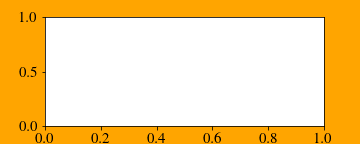

In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
fig, ax = plt.subplots(figsize=(5, 2), facecolor='orange')

In [57]:
import torch
import torch.distributions as dists
loc = torch.zeros(5, 3)
cov_factor = torch.ones(5, 3)
cov_diag = torch.ones(5, 3)

dist = dists.LowRankMultivariateNormal(loc, 
                                       cov_factor.unsqueeze(2), 
                                       cov_diag)
s = dist.rsample()
print(s)
dist = dists.Normal(loc, cov_factor)
s = dist.rsample()
print(s)

tensor([[ 0.1414,  2.1705,  0.3782],
        [ 1.9755,  0.8926,  2.9693],
        [ 0.7419, -1.4525, -0.1893],
        [-2.2417, -0.5971, -1.2312],
        [ 0.7685,  2.6206,  2.2369]])
tensor([[ 0.9009, -0.6143, -2.2231],
        [ 0.3649,  1.4136, -0.3182],
        [-0.3752, -0.5282,  0.4969],
        [ 1.3238,  0.5421, -0.5865],
        [ 1.1273, -1.4036,  0.9883]])


In [65]:
a = torch.randn(8, 2)
#b = a.unsqueeze(0).expand(4, -1).contiguous().view(-1)
#print(b)
#c = torch.cat((a.unsqueeze(0), torch.zeros(7, 2)), dim=0).view(-1)
#print(c)
print(a)
print(a.view(-1))

tensor([[ 0.3420, -0.2476],
        [-0.2930, -0.4686],
        [ 2.1650,  1.0503],
        [ 1.5685, -0.0579],
        [-0.6140, -0.0461],
        [-0.1360, -1.8361],
        [ 0.5452,  1.3795],
        [ 3.2291,  0.2497]])
tensor([ 0.3420, -0.2476, -0.2930, -0.4686,  2.1650,  1.0503,  1.5685, -0.0579,
        -0.6140, -0.0461, -0.1360, -1.8361,  0.5452,  1.3795,  3.2291,  0.2497])
